# kNN 分类算法


K最近邻(k-Nearest Neighbor，kNN)分类算法，是一个理论上比较成熟的方法，也是最简单的机器学习算法之一。该方法的思路是：***如果一个样本在特征空间中的k个最相似（即特征空间中最邻近）的样本中的大多数属于某一个类别，则该样本也属于这个类别***。kNN可以说是一种最直接的用来分类未知数据的方法,通过下面这张图帮助理解kNN的原理

![knn](images/knn.png)

简单来说，kNN可以看成：**有那么一堆你已经知道分类的数据，然后当一个新数据进入的时候，就开始跟训练数据里的每个点求距离，然后挑选这个训练数据最近的K个点，看看这几个点属于什么类型，然后用少数服从多数的原则，给新数据归类**。


## 1. 算法步骤

**输入：**
* 训练数据： $T=\{(x_1,y_1),(x_2,y_2), ..., (x_N,y_N)\}$, 其中$x_i \in X=\mathbb{R}^n$，$y_i \in Y = \{0, 1, ..., K-1\}$，i=1,2...N
* 用户输入数据：$x_u$

**输出：** 
* 预测的最优类别$y_{pred}$

**处理过程：**
1. 准备数据;
2. 计算测试数据与各个训练数据之间的**距离**；
3. 按照距离的递增关系进行排序；
4. 选取距离最小的`k`个点；
5. 确定前`k`个点所在类别的出现频率；
6. 返回前`k`个点中出现频率最高的类别作为测试数据的预测分类。



**深入思考：**
* 上述的处理过程，难点有哪些？
* 每个处理步骤如何用程序语言来描述？

### 1.1 距离计算

要度量空间中点距离的话，有好几种度量方式，比如常见的曼哈顿距离计算、欧式距离计算等等。不过通常 kNN 算法中使用的是欧式距离。这里只是简单说一下，拿二维平面为例，二维空间两个点的欧式距离计算公式如下：
$$
d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2}
$$

在二维空间其实就是计算 $(p_1,p_2)$ 和 $(q_1, q_2)$ 的距离。拓展到多维空间，则公式变成：
$$
d(p, q) = \sqrt{ (p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2 } = \sqrt{ \sum_{i=1,n} (p_i-q_i)^2}
$$

kNN 算法最简单粗暴的就是将 `预测点` 与 `所有点` 距离进行计算，然后保存并排序，选出前面 k 个值看看哪些类别比较多。


## 2. 机器学习的思维模型

针对kNN方法从原理、算法、到实现，可以得出机器学习的思维模型，在给定问题的情况下，是如何思考并解决机器学习问题。

![machine learning - methodology](images/ml_methodology.png)




上图是机器学习的经典的流程
* 问题：我们需要解决的问题是什么？
* 核心思想： 通过什么手段解决问题？
* 数学理论： 如何构建数学模型，使用什么数学方法？
* 算法： 如何将数学理论、处理流程转化成计算机可以实现的程序？
* 编程： 如何把算法变成可以计算机执行的程序？
* 测试: 如何使用训练、测试数据来验证算法
* 深入思考：所采用的方法能够取得什么效果，存在什么问题，如何改进？


## 3. 生成数据

/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-traindata.pdf")
/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-traindata.pdf")
/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-traindata.pdf")
/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-traindata.pdf")
/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-traindata.pdf")
/tmp/ipykernel_26441/180119110.py:46: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt

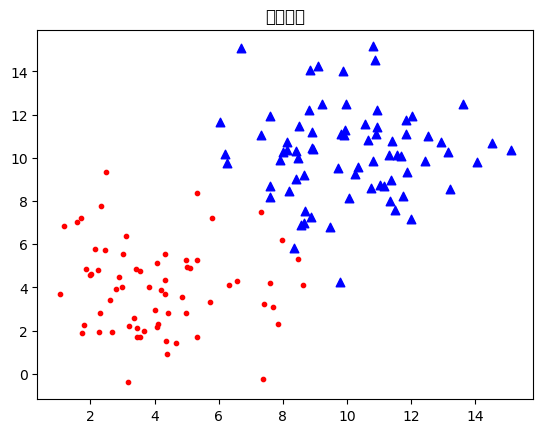

/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-testdata.pdf")
/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-testdata.pdf")
/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-testdata.pdf")
/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-testdata.pdf")
/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig("fig-res-knn-testdata.pdf")
/tmp/ipykernel_26441/180119110.py:57: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.save

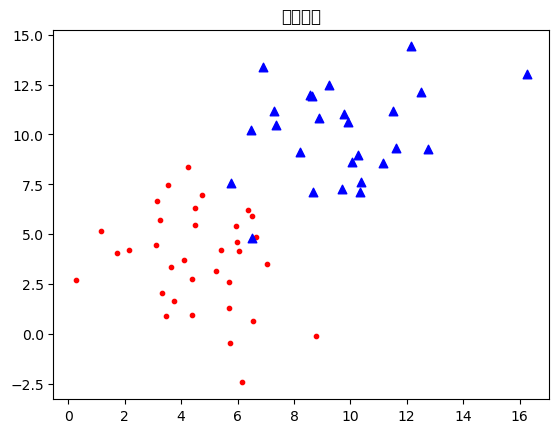

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 生成模拟数据
np.random.seed(314)

data_size1 = 100
x1 = np.random.randn(data_size1, 2)*2 + np.array([4,4])
y1 = [0 for _ in range(data_size1)]

data_size2 = 100
x2 = np.random.randn(data_size2, 2)*2 + np.array([10,10])
y2 = [1 for _ in range(data_size2)]


# 合并生成全部数据
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

data_size_all = data_size1 + data_size2
shuffled_index = np.random.permutation(data_size_all)
x = x[shuffled_index]
y = y[shuffled_index]

# 分割训练与测试数据
split_index = int(data_size_all*0.7)
x_train = x[:split_index]
y_train = y[:split_index]
x_test = x[split_index:]
y_test = y[split_index:]


# 绘制结果
for i in range(split_index):
    if y_train[i] == 0:
        plt.scatter(x_train[i,0],x_train[i,1], s=38, c = 'r', marker='.')
    else:
        plt.scatter(x_train[i,0],x_train[i,1], s=38, c = 'b', marker='^')   

#plt.rcParams['figure.figsize']=(12.0, 8.0)
#mpl.rcParams['font.family'] = 'SimHei'
plt.title("训练数据")
plt.savefig("fig-res-knn-traindata.pdf")
plt.show()

for i in range(data_size_all - split_index):
    if y_test[i] == 0:
        plt.scatter(x_test[i,0],x_test[i,1], s=38, c = 'r', marker='.')
    else:
        plt.scatter(x_test[i,0],x_test[i,1], s=38, c = 'b', marker='^')
#plt.rcParams['figure.figsize']=(12.0, 8.0)
#mpl.rcParams['font.family'] = 'SimHei'
plt.title("测试数据")
plt.savefig("fig-res-knn-testdata.pdf")
plt.show()

## 4. 最简单的程序实现

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


In [7]:
import numpy as np
import operator

def knn_distance(v1, v2):
    """计算两个多维向量的距离"""
    return np.sum(np.square(v1-v2))

def knn_vote(ys):
    """根据ys的类别，挑选类别最多一类作为输出"""
    vote_dict = {}
    for y in ys:
        if y not in vote_dict.keys():
            vote_dict[y] = 1
        else:
            vote_dict[y] += 1
                
    method = 1
    
    # 方法1 - 使用循环遍历找到类别最多的一类
    if method == 1:
        maxv = maxk = 0
        for y in np.unique(ys):
            if maxv < vote_dict[y]:
                maxv = vote_dict[y]
                maxk = y
        return maxk
    
    # 方法2 - 使用排序的方法
    if method == 2:
        sorted_vote_dict = sorted(vote_dict.items(), \
                                  #key=operator.itemgetter(1), \
                                  key=lambda x:x[1], \
                                  reverse=True)
        return sorted_vote_dict[0][0]
    

    
def knn_predict(x, train_x, train_y, k=3):
    """
    针对给定的数据进行分类
    参数
    x - 输入的待分类样本
    train_x - 训练数据的样本
    train_y - 训练数据的标签
    k - 最近邻的样本个数
    """
    dist_arr = [knn_distance(x, train_x[j]) for j in range(len(train_x))]
    sorted_index = np.argsort(dist_arr)
    top_k_index = sorted_index[:k]
    ys=train_y[top_k_index]
    return knn_vote(ys)
    

# 对每个样本进行分类
y_train_est = [knn_predict(x_train[i], x_train, y_train) for i in range(len(x_train))]
print(y_train_est)
print(y_train)

[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
[1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0
 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0
 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0]


In [8]:
y = knn_predict(x_train[0], x_train, y_train)
print(x_train[0], y)

[10.33908716  9.55754384] 1


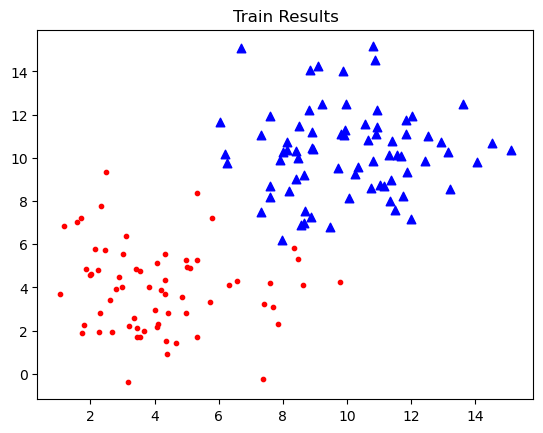

In [5]:
# 绘制结果
for i in range(len(y_train_est)):
    if y_train_est[i] == 0:
        plt.scatter(x_train[i,0],x_train[i,1], s=38, c = 'r', marker='.')
    else:
        plt.scatter(x_train[i,0],x_train[i,1], s=38, c = 'b', marker='^')   
#plt.rcParams['figure.figsize']=(12.0, 8.0)
mpl.rcParams['font.family'] = 'SimHei'
plt.title("Train Results")
plt.savefig("fig-res-knn-train-res.pdf")
plt.show()

In [7]:
# 计算训练数据的精度
n_correct = 0
for i in range(len(x_train)):
    if y_train_est[i] == y_train[i]:
        n_correct += 1
accuracy = n_correct / len(x_train) * 100.0
print("Train Accuracy: %f%%" % accuracy)

Train Accuracy: 97.142857%


In [8]:
# 计算测试数据的精度
y_test_est = [knn_predict(x_test[i], x_train, y_train, 3) for i in range(len(x_test))]
n_correct = 0
for i in range(len(x_test)):
    if y_test_est[i] == y_test[i]:
        n_correct += 1
accuracy = n_correct / len(x_test) * 100.0
print("Test Accuracy: %f%%" % accuracy)
print(n_correct, len(x_test))

Test Accuracy: 96.666667%
58 60


## 5. 通过类实现kNN程序

In [9]:
import numpy as np
import operator

class KNN(object):
    def __init__(self, k=3):
        """对象构造函数，参数为：
        k - 近邻个数"""
        self.k = k

    def fit(self, x, y):
        """拟合给定的数据，参数为：
        x - 样本的特征；y - 样本的标签"""
        self.x = x
        self.y = y
        return self

    def _square_distance(self, v1, v2):
        """计算两个样本点的特征空间距离，参数为：
        v1 - 样本点1；v2 - 样本点2"""
        return np.sum(np.square(v1-v2))

    def _vote(self, ys):
        """投票算法，参数为：
        ys - k个近邻样本的类别"""
        ys_unique = np.unique(ys)
        vote_dict = {}
        for y in ys:
            if y not in vote_dict.keys():
                vote_dict[y] = 1
            else:
                vote_dict[y] += 1
        sorted_vote_dict = sorted(vote_dict.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_vote_dict[0][0]

    def predict(self, x):
        y_pred = []
        for i in range(len(x)):
            dist_arr = [self._square_distance(x[i], self.x[j]) for j in range(len(self.x))]
            sorted_index = np.argsort(dist_arr)
            top_k_index = sorted_index[:self.k]
            y_pred.append(self._vote(ys=self.y[top_k_index]))
        return np.array(y_pred)

    def score(self, y_true=None, y_pred=None):
        if y_true is None and y_pred is None:
            y_pred = self.predict(self.x)
            y_true = self.y
        score = 0.0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                score += 1
        score /= len(y_true)
        return score

In [11]:
# data preprocessing
#x_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))
#x_test = (x_test - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

# knn classifier
clf = KNN(k=5)
train_acc = clf.fit(x_train, y_train).score() * 100.0

y_test_pred = clf.predict(x_test)
test_acc = clf.score(y_test, y_test_pred) * 100.0

print('train accuracy: %f %%' % train_acc)
print('test accuracy: %f %%' % test_acc)

train accuracy: 97.857143 %
test accuracy: 96.666667 %


## 6. sklearn program

In [26]:
#% matplotlib inline

import matplotlib.pyplot as plt
from sklearn import datasets, neighbors, linear_model

# load data
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

print("Feature dimensions: ", X_digits.shape)
print("Label dimensions:   ", y_digits.shape)


Feature dimensions:  (1797, 64)
Label dimensions:    (1797,)


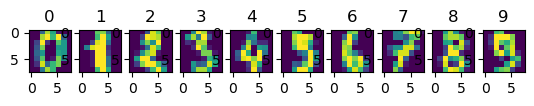

In [27]:
# plot sample images
nplot = 10
fig, axes = plt.subplots(nrows=1, ncols=nplot)

for i in range(nplot):
    img = X_digits[i].reshape(8, 8)
    axes[i].imshow(img)
    axes[i].set_title(y_digits[i])
plt.show()
fig.set_size_inches(16,9)
fig.savefig('fig-res-digits.pdf')

In [28]:
# split train / test data
n_samples = len(X_digits)
n_train = int(0.7 * n_samples)

X_train = X_digits[:n_train]
y_train = y_digits[:n_train]
X_test = X_digits[n_train:]
y_test = y_digits[n_train:]


KNN score: 0.964815
[ 0.  0.  5. 12.  0.  0.  0.  0.  0.  0. 14. 10. 14. 12.  0.  0.  0.  2.
 16. 16.  8. 11.  2.  0.  0.  3. 16. 11.  0.  9.  3.  0.  0.  5. 12.  2.
  0. 12.  4.  0.  0.  1. 12.  0.  0. 13.  3.  0.  0.  0. 13.  6.  8. 13.
  0.  0.  0.  0.  3. 14. 12.  3.  0.  0.]
[0]


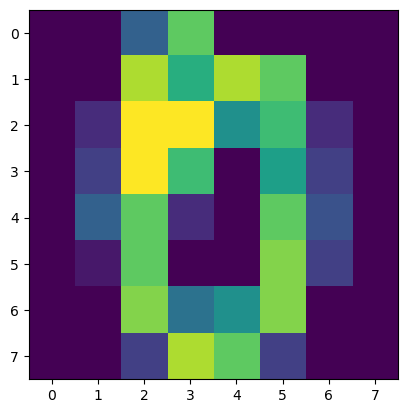

In [31]:
# do KNN classification
knn = neighbors.KNeighborsClassifier()
#logistic = linear_model.LogisticRegression()

#knn.fit(x_train, y_train)

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
#print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))


sample_i = 1
y = knn.predict([X_test[sample_i]])
print(X_test[sample_i])
print(y)

img = X_test[sample_i].reshape(8, 8)
plt.imshow(img)
plt.show()

## 7. 深入思考

* 如果输入的数据非常多，怎么快速进行距离计算？
    - KD-Tree详解: 从原理到编程实现 https://blog.csdn.net/qq_42688495/article/details/124049811
    - [sklean kd-tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) 
    - Fast Library for Approximate Nearest Neighbors （FLANN）
    - [PyNNDescent for fast Approximate Nearest Neighbors](https://pynndescent.readthedocs.io/en/latest/)
* 如何选择最好的`k`？
    - https://zhuanlan.zhihu.com/p/143092725


## 参考资料
* [Digits Classification Exercise](http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html)
* [kNN算法的原理与实现](https://zhuanlan.zhihu.com/p/36549000)